### Манацкая Кристина

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Данные без обработки

Считываем файл в DataFrame cars_Moldova

In [2]:
df = pd.read_csv('cars_moldova_clean.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [3]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

### Линейная регрессия

Разбиение данных на тренеровочные и тестовые

In [4]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Введем функция потерь и расчета

In [5]:
def forward(weights, inputs):
    return inputs.dot(weights.T)

def loss_func(predicts, labels):
        return np.square(predicts - labels)  

Протестируем обе функции

In [6]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-0.81117273 -0.58516591  0.10482003 -0.43616798]
-0.8018726117599 7750.0 7750.80187261176


In [7]:
def grad_loss(predicts, labels, inputs):
    return 2*(predicts - labels)*inputs/inputs.size

Проведем расчет градиента ошибки

In [8]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-1.10427648 -1.46326365 -1.69881058 -0.43174941]
[-7.79430649e+06 -7.55788049e+08 -6.97650506e+06 -6.87080044e+07]


Оптимизация методом градиентного спуска

In [9]:
def update_weights(grad, weights, lerning_rate):
    return weights - lerning_rate*grad

Проведем обновление весовых параметров

In [10]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  77941.96062677 7557879.02213409   69763.35182386  687079.61237766]


Проведём процедуру инициализации, с использованием небольших случайных значений

In [11]:
def weights_init(weights, random_state=42):
    if np.ndim(weights)<1:
        weights = np.zeros(weights)
        
    np.random.seed(random_state)
    return np.random.randn(*weights.shape)/np.sqrt(weights.size)

Инициализация весов

In [12]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.24835708, -0.06913215,  0.32384427,  0.76151493])

Создадим процедуру обучения

In [13]:
def fit(X, y, weights, lr,  epochs=30):
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape)
        loss = 0
        
        for m in range(X.shape[0]): 
            yhat  = forward(weights, X[m,:])
            grad += grad_loss(yhat,  y[m], X[m,:])
            loss += loss_func(yhat,  y[m])

        weights = update_weights(grad/X.shape[0],weights, lr)  
        cost[i] = loss/X.shape[0]
    
    return weights, cost

Протестируем обучение

In [14]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks()
    plt.yticks();  

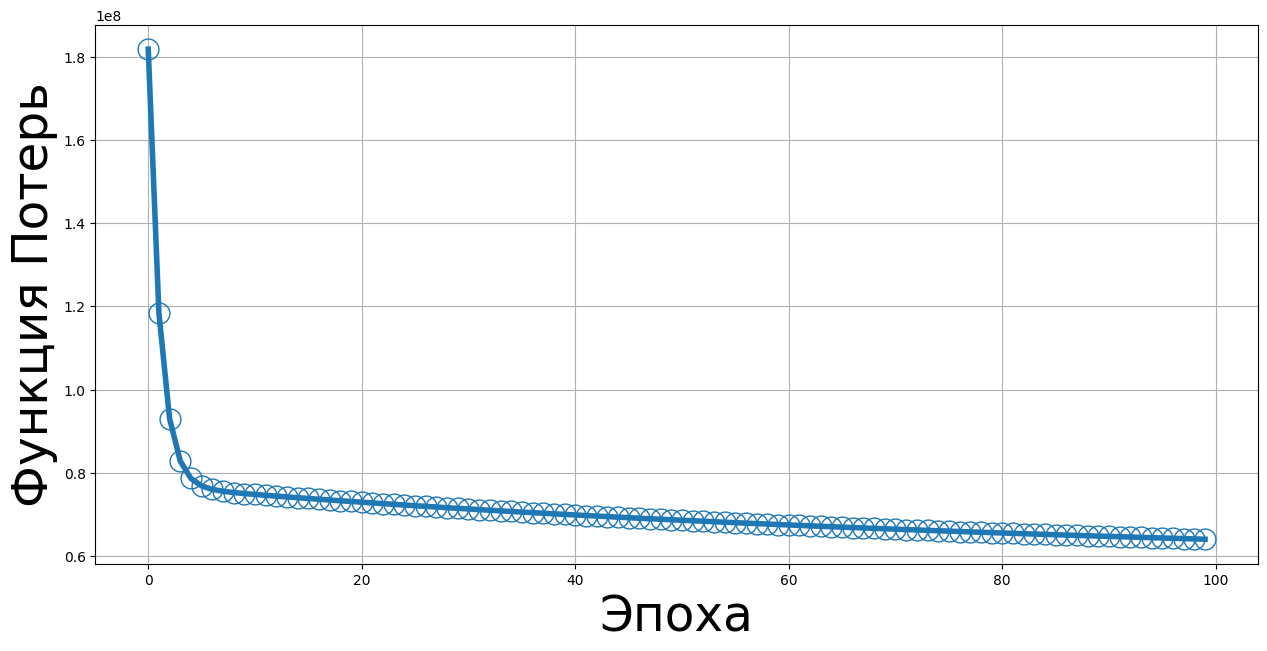

In [15]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

Метрика  $R^2$ (проверка, как точно предсказывает функция)

In [16]:
def predict(weights, inputs):
    yhat = np.zeros(inputs.shape[0])
    
    for m in range(inputs.shape[0]):
        yhat[m] = inputs[m,:].dot(weights.T)
    
    return yhat

Как выглядят наши ответы на фоне реальных

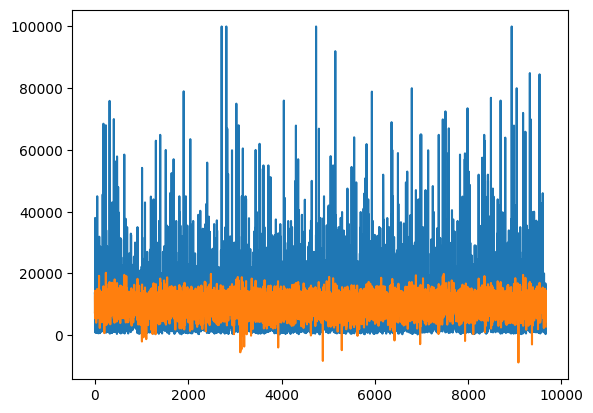

In [17]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

Text(0, 0.5, 'predicted')

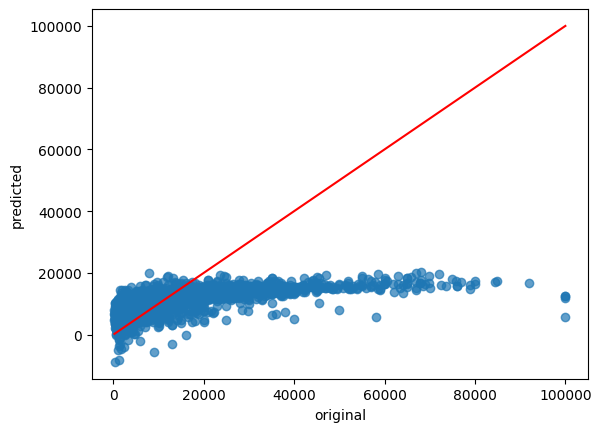

In [18]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [19]:
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

Коэффициент детерминации

In [20]:
r2_score(weights, X_test, y_test)

0.30775705120132035

In [21]:
BATCH = 5000

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = BATCH, random_state = 42):
    
    np.random.seed(random_state)
    
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape)
        loss = 0
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad/batch_size,weights, lr)  
        cost[i] =loss/batch_size
    
    return weights, cost

0.37078971359420776


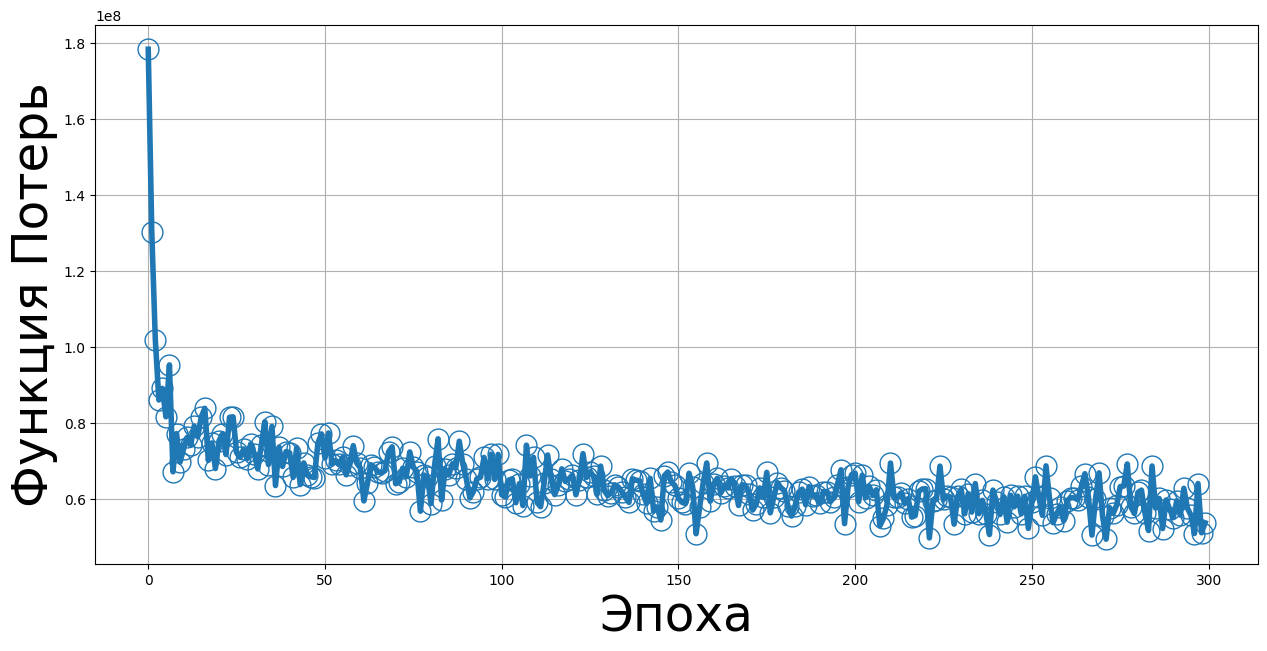

In [22]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

Обьединение всех частей в один класс линейной регресии

In [23]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

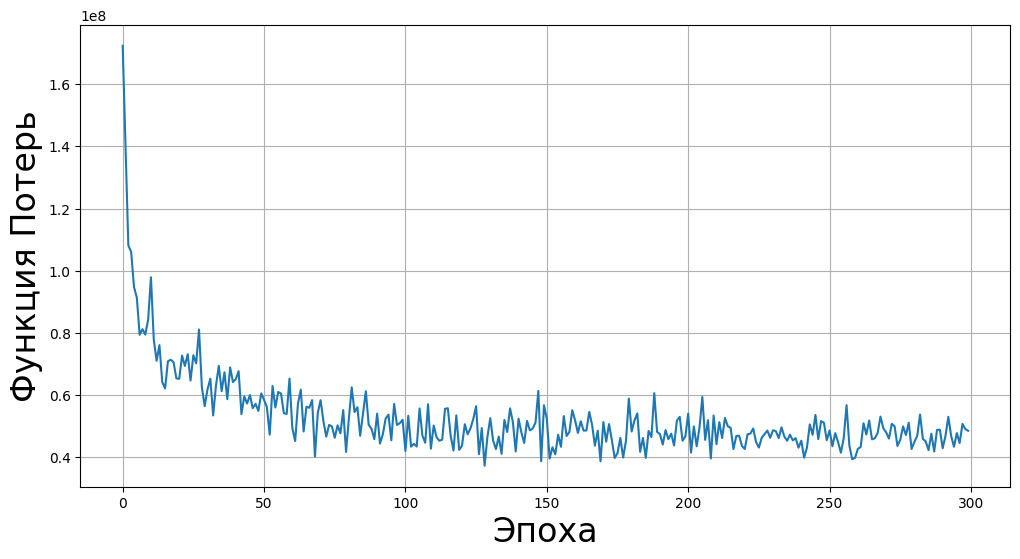

train R2: 0.4869; test R2: 0.4767


In [24]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

In [25]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 )

Визуализация веса

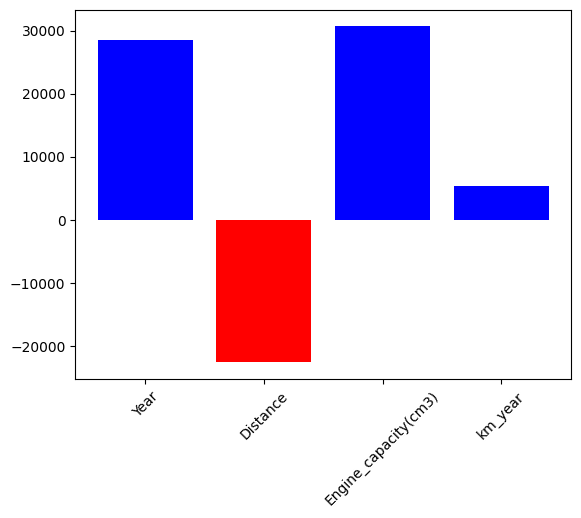

In [26]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [27]:
np.sum(np.abs(w))

86990.68957974161

### Стандартизация

In [28]:
df = pd.read_csv('cars_moldova_standardization.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [29]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

### Линейная регрессия

Разбиение данных на тренеровочные и тестовые

In [30]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values # x = все параметры кроме Price, y = Price

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1007.0 KB


,0,1,2
22549,0.40,0.011012,0.291667
22550,0.74,0.208921,0.270833
22551,0.84,0.155127,0.270833
22552,0.84,0.219922,0.229167
22553,0.94,0.049905,0.375000


Протестируем обе функции

In [31]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-0.1382643  -1.27468225  0.19138615]
-0.3677222706589184 7750.0 7750.367722270659


Проведем расчет градиента ошибки

In [32]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-1.30424901 -0.01104846  0.22753761]
[-1.03912832e+07 -1.00760826e+09 -9.30099935e+06]


Проведем обновление весовых параметров

In [33]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103911.52738227 10076082.61853847    93010.22104149]


Инициализация весов

In [34]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Протестируем обучение

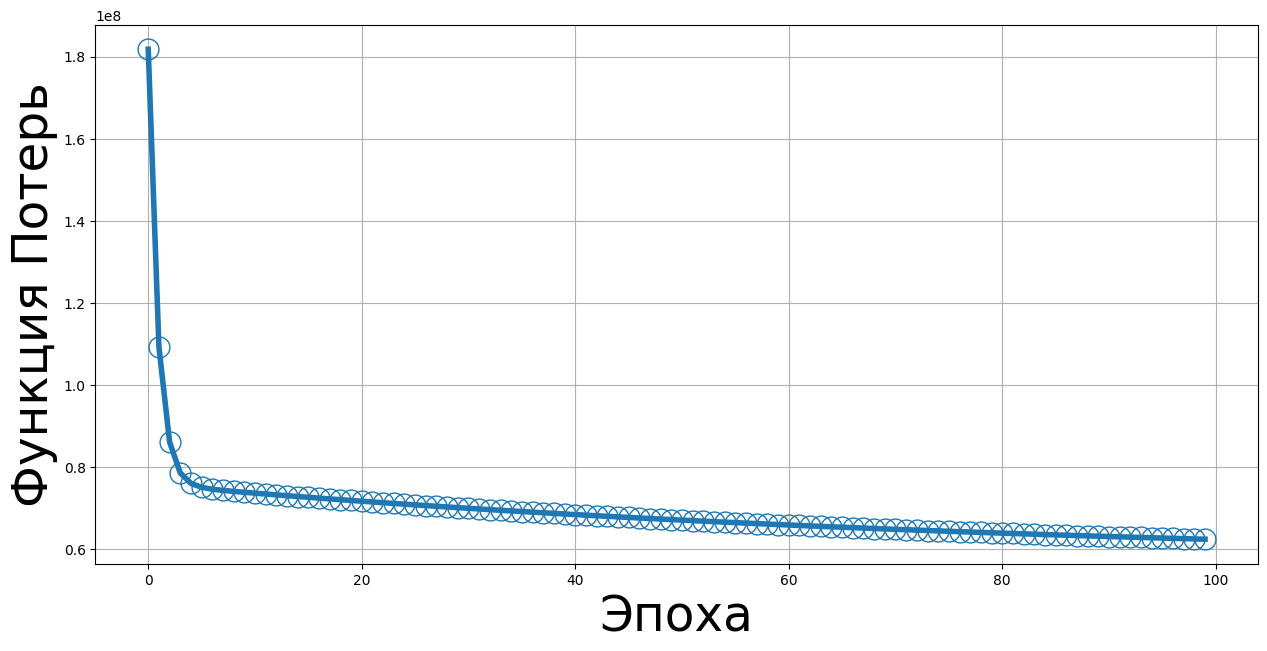

In [35]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

Как выглядят ответы на фоне реальных

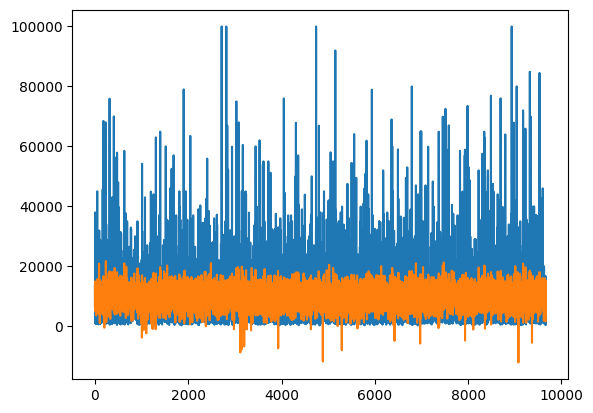

In [36]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

Text(0, 0.5, 'predicted')

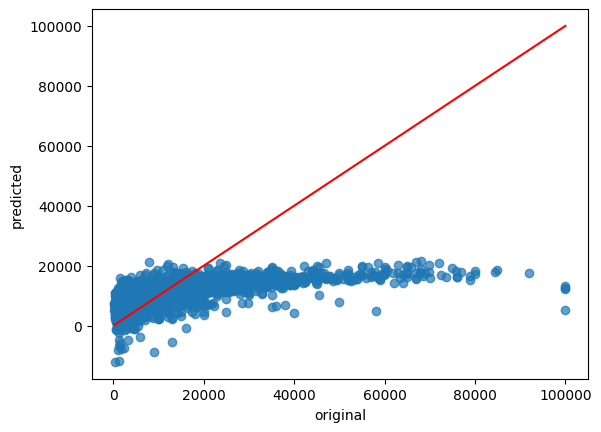

In [37]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

Коэффициент детерминации

In [56]:
r2_score(weights, X_test, y_test)

0.32257106315237305

0.32257106315237305


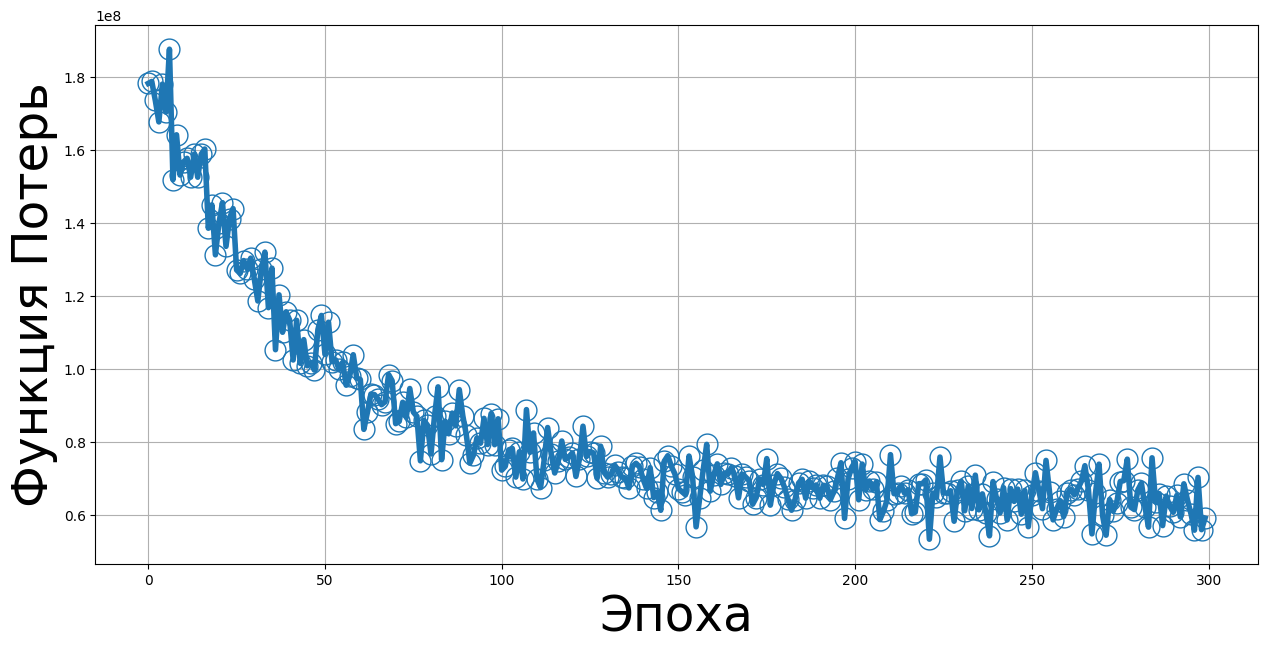

In [57]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

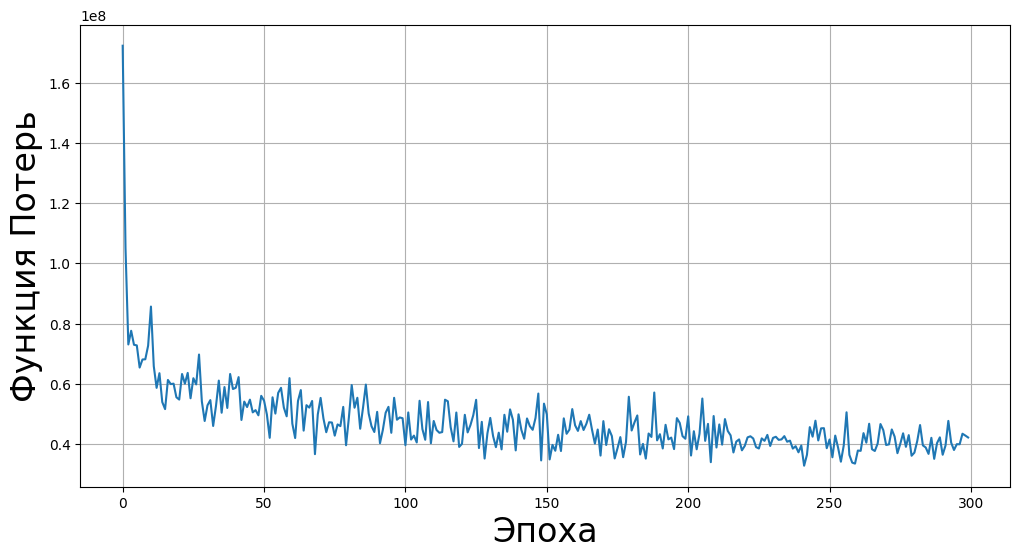

train R2: 0.5646; test R2: 0.5652


In [59]:
regr = LinearRegression(learning_rate=0.1,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Вывод_1: точность немного повысилась

Визуализация веса

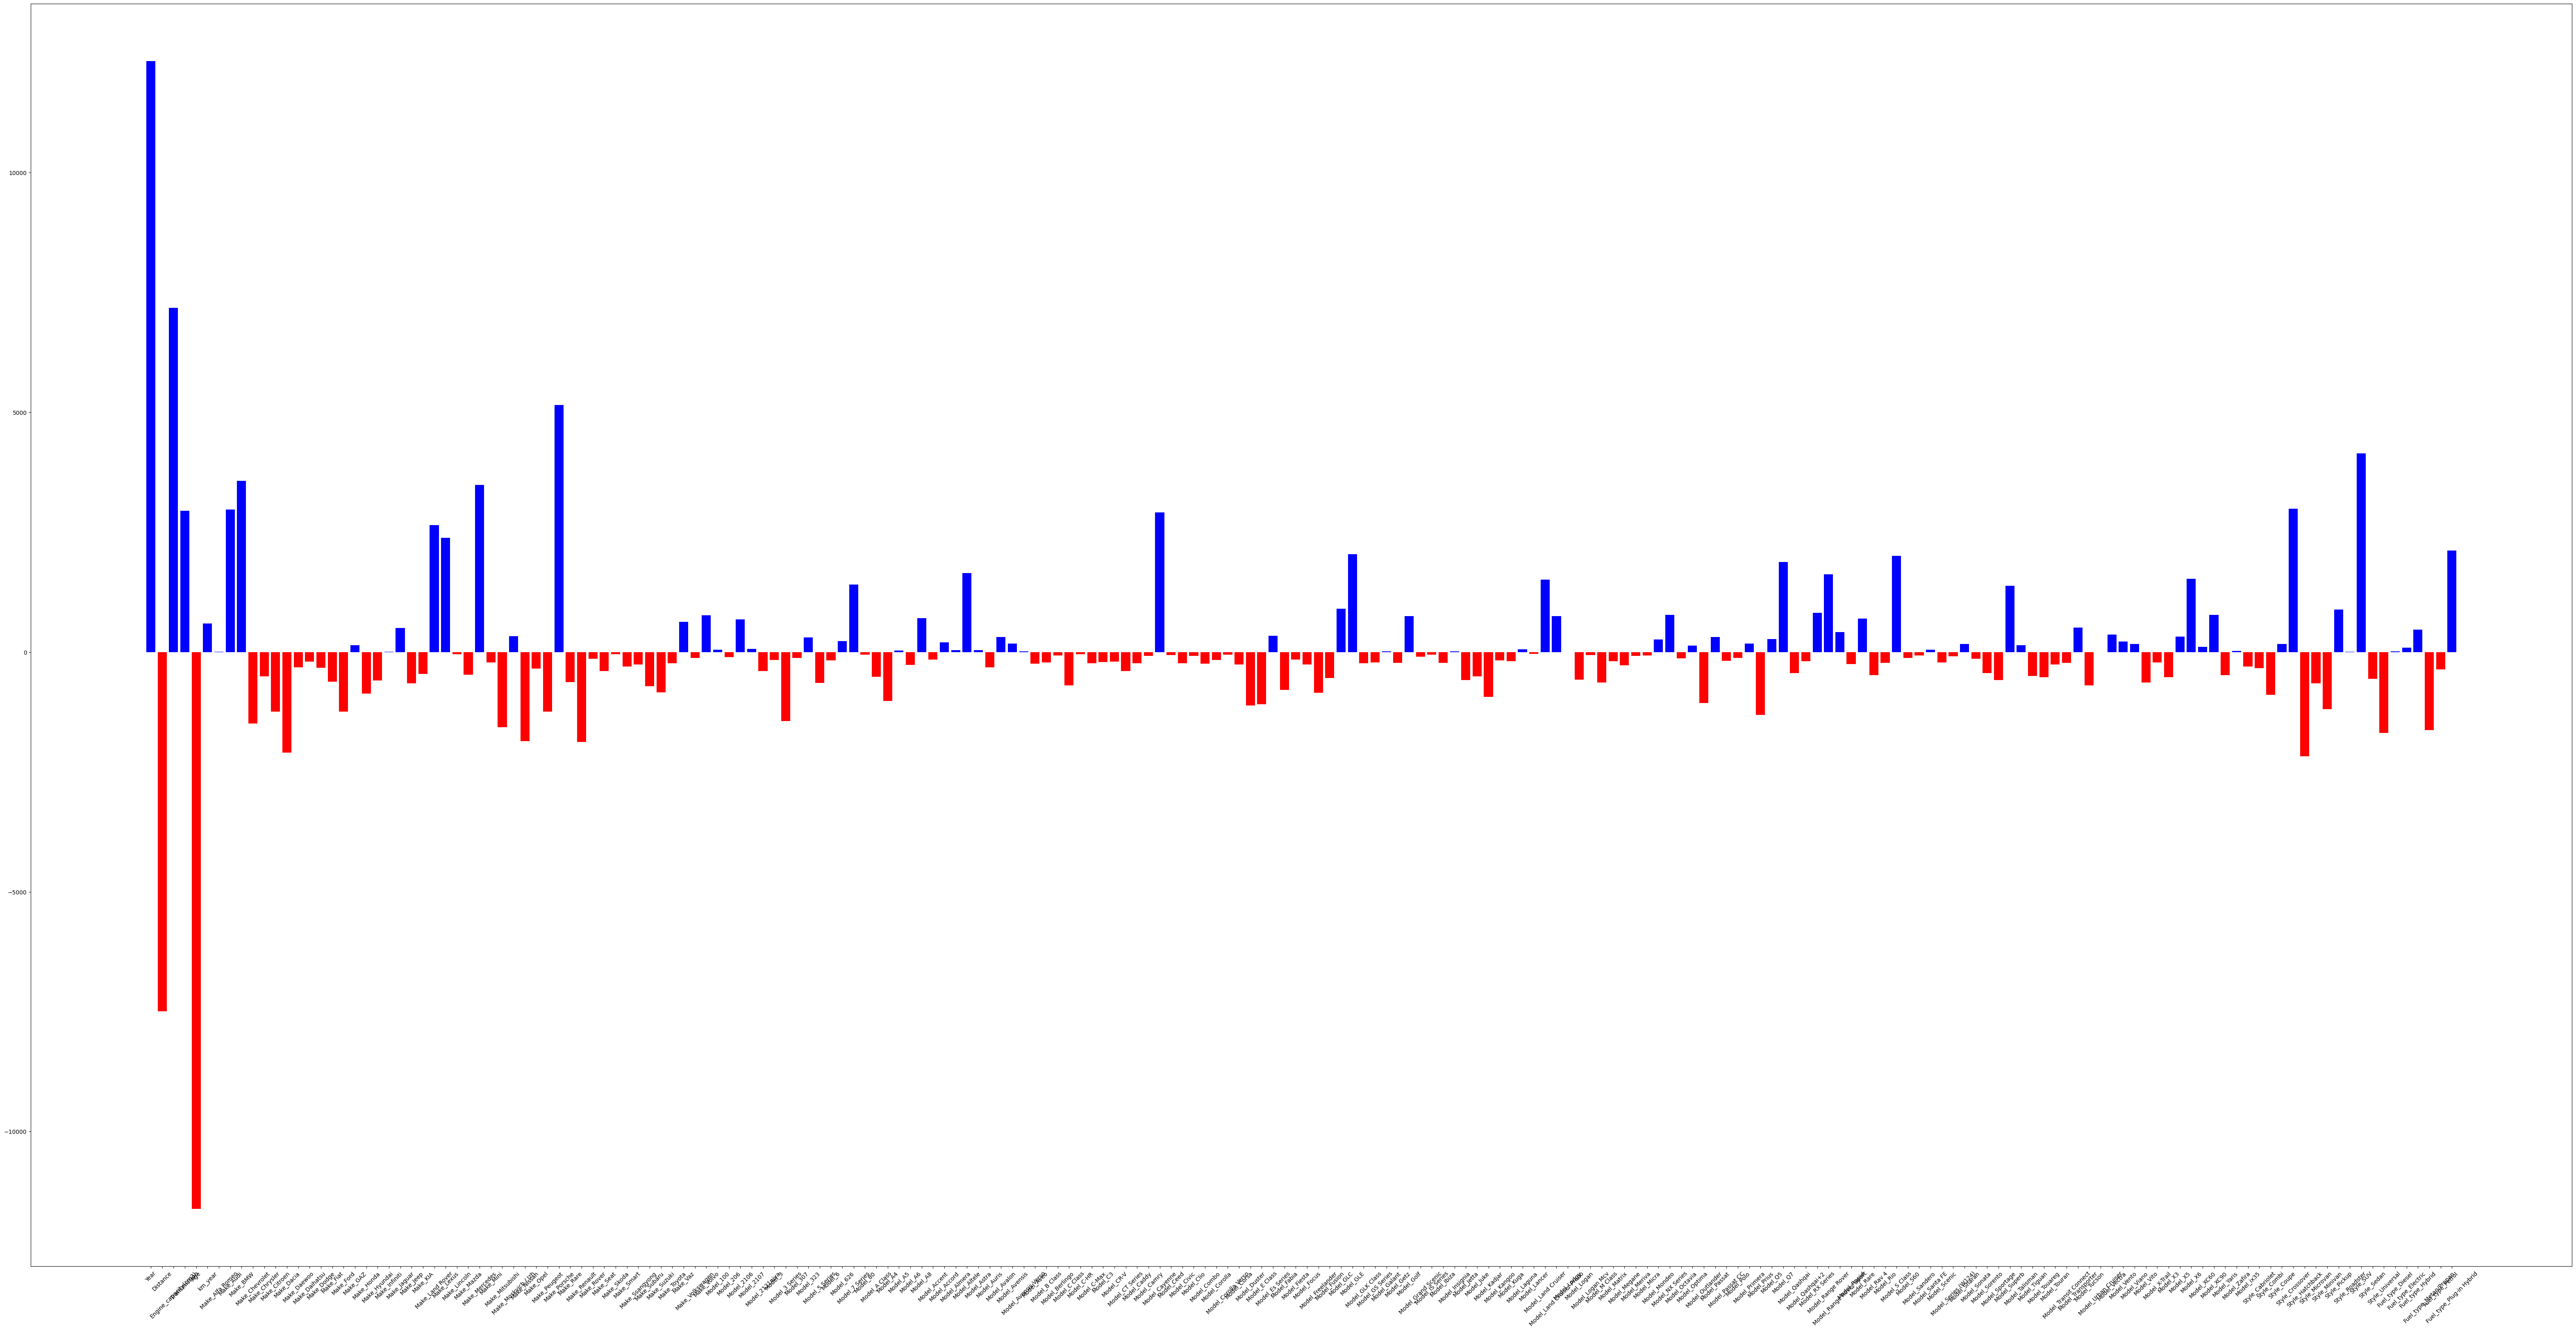

In [61]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(80, 40))
vis_weigths(w, features_names)

In [62]:
np.sum(np.abs(w))

167047.5694630883

### One-hot кодирование

In [38]:
df = pd.read_csv('cars_moldova_onehot.csv', delimiter = ',')
df

,Year,Distance,Engine_capacity(cm3),Transmission,Price(euro),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,2011,195000.0,1800.0,1,7750.0,11,17727.272727,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2014,135000.0,1500.0,0,8550.0,8,16875.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,2012,110000.0,1500.0,0,6550.0,10,11000.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,2006,200000.0,1600.0,0,4100.0,16,12500.000000,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2000,300000.0,2200.0,0,3490.0,22,13636.363636,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,2016,88000.0,1800.0,1,11500.0,6,14666.666667,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32216,2002,225000.0,1800.0,0,4400.0,20,11250.000000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32217,2015,89000.0,1500.0,0,7000.0,7,12714.285714,0,0,0,...,0,0,0,1,1,0,0,0,0,0
32218,2006,370000.0,2000.0,0,4000.0,16,23125.000000,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [39]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Transmission', 'Price(euro)', 'Age', 'km_year', 'Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo', 'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford', 'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes', 'Make_Mini', 'Make_Mitsubishi', 'Make_Moskvich / Izh', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Rare', 'Make_Renault', 'Make_Rover', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong', 'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz', 'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206', 'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3', 'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series', 'Model_6', 'Model_626', 

### Линейная регрессия

In [40]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values # x = все параметры кроме Price, y = Price

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Columns: 205 entries, Year to Fuel_type_Plug-in Hybrid
dtypes: float64(4), int64(201)
memory usage: 50.4 MB


,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
22549,0.40,0.011012,0.291667,0.0,0.60,0.005179,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22550,0.74,0.208921,0.270833,1.0,0.26,0.297166,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22551,0.84,0.155127,0.270833,0.0,0.16,0.343601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22552,0.84,0.219922,0.229167,1.0,0.16,0.487865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22553,0.94,0.049905,0.375000,1.0,0.06,0.248497,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[ 1.52302986 -0.23415337 -0.23413696  1.57921282  0.76743473 -0.46947439
  0.54256004 -0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783
 -0.56228753 -1.01283112  0.31424733 -0.90802408 -1.4123037   1.46564877
 -0.2257763   0.0675282  -1.42474819 -0.54438272  0.11092259 -1.15099358
  0.37569802 -0.60063869 -0.29169375 -0.60170661  1.85227818 -0.01349722
 -1.05771093  0.82254491 -1.22084365  0.2088636  -1.95967012 -1.32818605
  0.19686124  0.73846658  0.17136828 -0.11564828 -0.3011037  -1.47852199
 -0.71984421 -0.46063877  1.05712223  0.34361829 -1.76304016  0.32408397
 -0.38508228 -0.676922    0.61167629  1.03099952  0.93128012 -0.83921752
 -0.30921238  0.33126343  0.97554513 -0.47917424 -0.18565898 -1.10633497
 -1.19620662  0.81252582  1.35624003 -0.07201012  1.0035329   0.36163603
 -0.64511975  0.36139561  1.53803657 -0.03582604  1.56464366 -2.6197451
  0.8219025   0.08704707 -0.29900735  0.09176078 -1.98756891 -0.21967189
  0.35711257  1.47789404 -0.51827022 -0.8084936  -0.

In [42]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[ 0.51378595  0.51504769  3.85273149  0.57089051  1.13556564  0.95400176
  0.65139125 -0.31526924  0.75896922 -0.77282521 -0.23681861 -0.48536355
  0.08187414  2.31465857 -1.86726519  0.68626019 -1.61271587 -0.47193187
  1.0889506   0.06428002 -1.07774478 -0.71530371  0.67959775 -0.73036663
  0.21645859  0.04557184 -0.65160035  2.14394409  0.63391902 -2.02514259
  0.18645431 -0.66178646  0.85243333 -0.79252074 -0.11473644  0.50498728
  0.86575519 -1.20029641 -0.33450124 -0.47494531 -0.65332923  1.76545424
  0.40498171 -1.26088395  0.91786195  2.1221562   1.03246526 -1.51936997
 -0.48423407  1.26691115 -0.70766947  0.44381943  0.77463405 -0.92693047
 -0.05952536 -3.24126734 -1.02438764 -0.25256815 -1.24778318  1.6324113
 -1.43014138 -0.44004449  0.13074058  1.44127329 -1.43586215  1.16316375
  0.01023306 -0.98150865  0.46210347  0.1990597  -0.60021688  0.06980208
 -0.3853136   0.11351735  0.66213067  1.58601682 -1.2378155   2.13303337
 -1.9520878  -0.1517851   0.58831721  0.28099187 -0.

In [43]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[ 1.52777746e+03  1.48094208e+05  1.37087144e+03  1.33034535e+00
  9.48956883e+00  1.34640170e+04  6.51391251e-01 -3.15269245e-01
  7.58969220e-01 -7.72825215e-01 -2.36818607e-01 -4.85363548e-01
  8.18741394e-02  2.31465857e+00 -1.86726519e+00  6.86260190e-01
 -1.61271587e+00 -4.71931866e-01  1.08895060e+00  6.42800191e-02
 -1.07774478e+00 -7.15303709e-01  6.79597749e-01 -7.30366632e-01
  2.16458590e-01  4.55718399e-02 -6.51600348e-01  2.14394409e+00
  6.33919022e-01 -2.02514259e+00  1.86454315e-01 -6.61786465e-01
  8.52433335e-01 -7.92520738e-01 -1.14736441e-01  5.04987279e-01
  8.65755194e-01 -1.20029641e+00 -3.34501236e-01 -4.74945311e-01
 -6.53329233e-01  1.76545424e+00  4.04981711e-01 -1.26088395e+00
  9.17861947e-01  2.12215620e+00  1.79192010e+00 -1.51936997e+00
 -4.84234073e-01  1.26691115e+00 -7.07669466e-01  4.43819428e-01
  7.74634053e-01 -9.26930472e-01 -5.95253561e-02 -3.24126734e+00
 -1.02438764e+00 -2.52568151e-01 -1.24778318e+00  1.63241130e+00
 -1.43014138e+00 -4.40044

In [44]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.03477695, -0.00968044,  0.04534727,  0.10663342, -0.01639402,
       -0.01639287,  0.11056701,  0.05373118, -0.03286978,  0.0379868 ,
       -0.03244573, -0.0326076 ,  0.01694075, -0.13395641, -0.1207684 ,
       -0.039368  , -0.07091236,  0.02200171, -0.0635744 , -0.09888104,
        0.10261594, -0.0158075 ,  0.00472792, -0.09975233, -0.03811441,
        0.00776613, -0.08058567,  0.02630412, -0.04205312, -0.02042265,
       -0.04212789,  0.12968541, -0.00094499, -0.07405458,  0.05758966,
       -0.08547615,  0.01462338, -0.13720435, -0.09299162,  0.01378304,
        0.051703  ,  0.01199818, -0.008097  , -0.02108148, -0.10351724,
       -0.05039918, -0.03225116,  0.07401336,  0.02405809, -0.1234375 ,
        0.02269042, -0.02696115, -0.04739402,  0.04282591,  0.0721844 ,
        0.06520265, -0.05875698, -0.0216492 ,  0.02319308,  0.06830182,
       -0.03354891, -0.01299873, -0.07745894, -0.08375122,  0.05688819,
        0.0949558 , -0.00504172,  0.07026136,  0.02531959, -0.04

Протестируем обучение

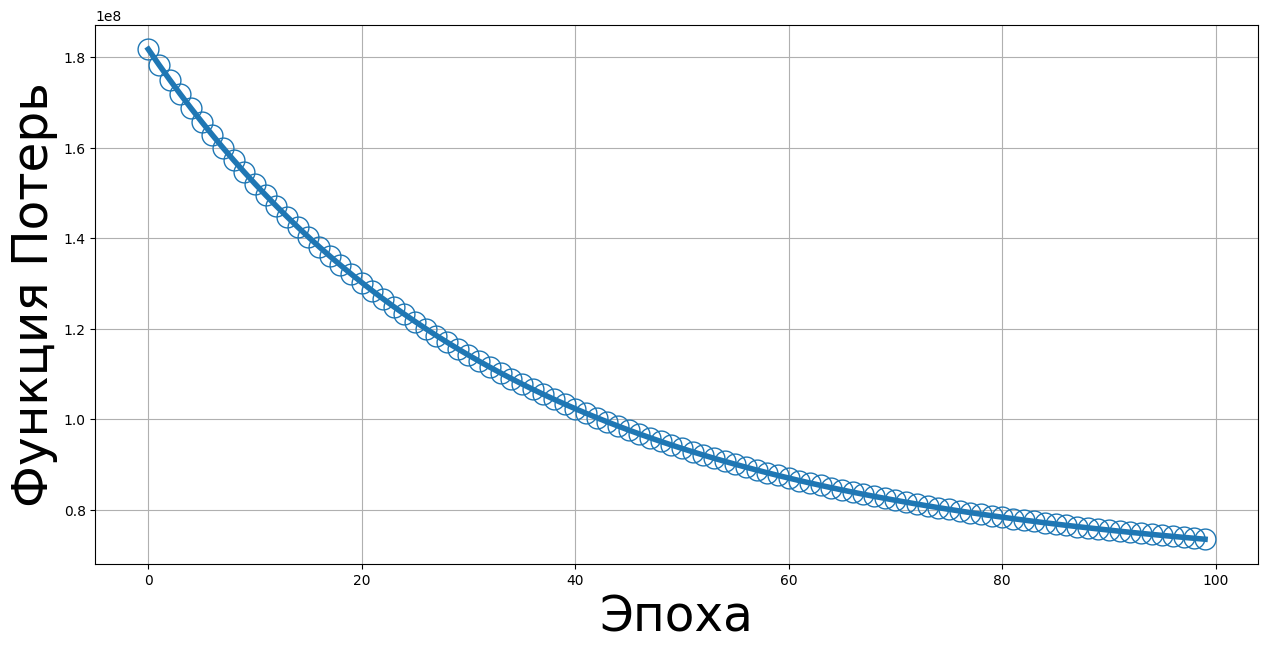

In [45]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

Как выглядят ответы на фоне реальных

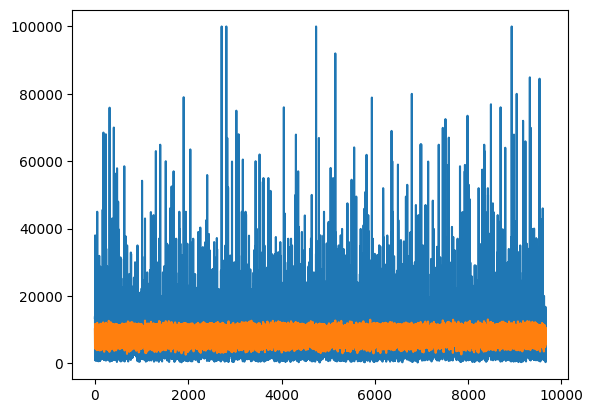

In [46]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

Text(0, 0.5, 'predicted')

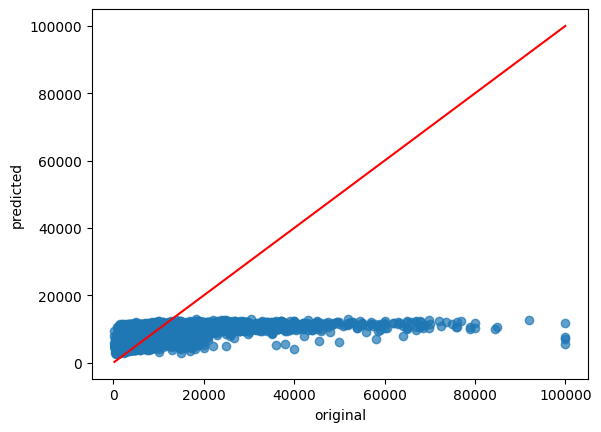

In [47]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [48]:
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

In [49]:
r2_score(weights, X_test, y_test)

0.21155395918929587

In [50]:
BATCH = 5000

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = BATCH, random_state = 42):
    
    np.random.seed(random_state)
    
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape);
        loss = 0;
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad/batch_size,weights, lr)  
        cost[i] =loss/batch_size
    
    return weights, cost

0.32257106315237305


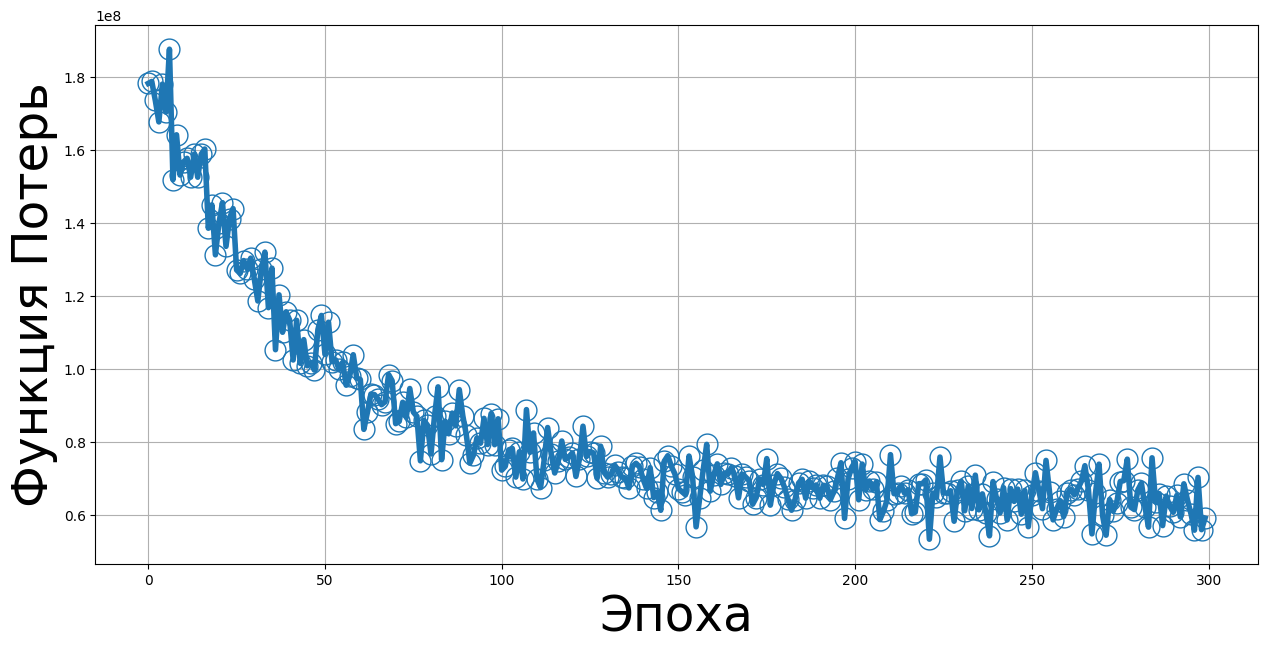

In [51]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

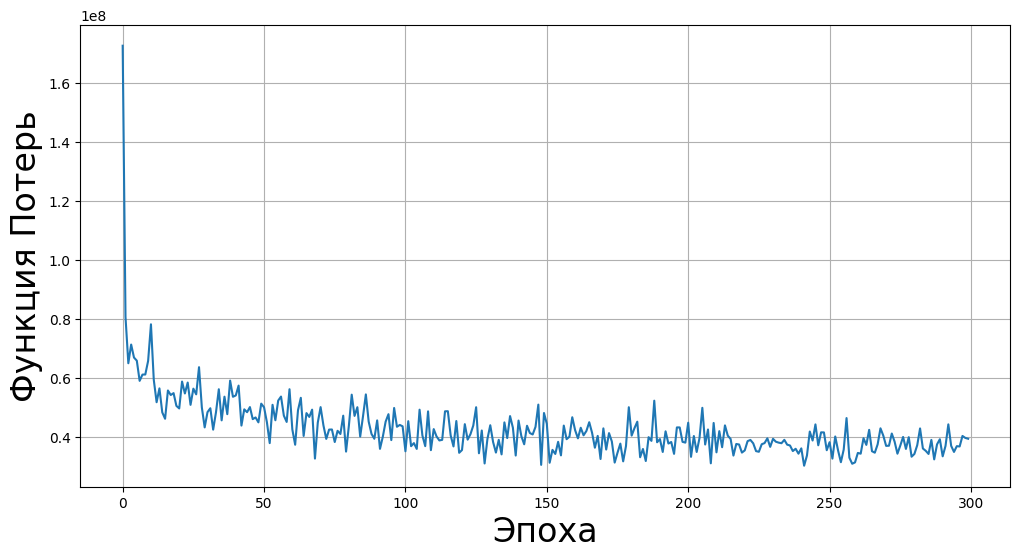

train R2: 0.5954; test R2: 0.5927


In [52]:
regr = LinearRegression(learning_rate=0.2,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Вывод_2: точность ещё немного повысилась

Посмотрим веса

In [53]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 )

In [54]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(199,100))
vis_weigths(w, features_names)

In [55]:
np.sum(np.abs(w))

240025.54368806857


### 2.2 Оцените влияние разных типов предварительной обработки на результат

С предварительной обработкой точность регрессии повышается

### 2.3 Сравните результаты модели при использовании только числовых признаков и при добавлении категориальных признаков с помощью one-hot кодирования 

При добавлении категориальных признаков с помощью one-hot кодирования точность регрессии повышается 

### 2.4 Оцените наиболее значимые признаки для модели проанализировав веса

Year, Engine_capacity(cm3)